# ***<u>The Future of Basketball Players</u>***

# Set up Environment

In [1]:
# The usuals
import os
import sys
import subprocess
import pandas as pd
import numpy as np

# Useful stuff
from zipfile import ZipFile
from joblib import dump, load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame, display
import random
from statistics import mode
from datetime import datetime
from scipy.stats import uniform, randint

# SkLearn bits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Autoreload
%load_ext autoreload
%autoreload

In [2]:
# Ensure the directory is correct... every time.
for i in range(5):
    if not os.getcwd().lower() == subprocess.run("git rev-parse --show-toplevel", stdout=subprocess.PIPE).stdout.decode("utf-8").replace("/","\\").strip().lower():
        os.chdir(".."),
    else:
        break

In [3]:
# Set up sys path environment
if not os.path.abspath(".") in sys.path:
    sys.path.append(os.path.abspath("."))
else:
    sys.path.remove(os.path.abspath("."))
    sys.path.append(os.path.abspath("."))

## Custom Globals

In [4]:
# Import customs
from src.utils.misc import get_list_proportions
from src.utils.performance import TicToc
from src.models.performance import save_reg_perf
from src.models.train_model import easy_random_search
from src.models.null import NullModel

In [5]:
# Instantiate Global Classes
t = TicToc()

## Get Data

In [6]:
# Check & Create directories
for dir in ["./data/processed", "./models"]:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [7]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ./data/raw --force --quiet

# Unzip the data
with ZipFile("./data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("./data/raw")

# Delete the zip file
if os.path.exists("./data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("./data/raw/uts-advdsi-nba-career-prediction.zip")

name                    size  creationDate         
---------------------  -----  -------------------  
train.csv              701KB  2021-01-30 23:13:35  
test.csv               323KB  2021-01-30 23:13:35  
sample_submission.csv   40KB  2021-01-30 23:13:35  


In [8]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("./data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [9]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("./data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("./data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("./data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

In [10]:
# Generate Data Dictionary
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id_old": "Previous Player Identifier"
    , "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG%": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P%": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT%": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

In [11]:
# View data profile
display(data.describe())

# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    display(IFrame(src="InitialReport.html", width="100%", height=600))
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,1.392525,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


# Fix Data

## Data Manipulation

**Steps:**

1. Drop the `ID` column
1. Pop the `target` column
1. Convert to absolute values
1. Add the `HAND` feature, which is: `STL`$\div$`TOV`
1. Calculate the `PER` feature
1. Drop the `MIN`, `AST`, `STL` features
1. Scale the features
1. Split in to train/test
1. Run oversampling function (SMOTE)

In [12]:
# Drop ID
data.drop(['Id','Id_old'], axis=1, inplace=True)

In [13]:
# Pop targ
feat = data.iloc[:,:-1]
targ = data.iloc[:,-1]

In [14]:
# Convert to positive values
feat = abs(feat)

In [15]:
# Add HAND variable
feat["HAND"] = feat["STL"]/feat["TOV"]

In [16]:
# Add PER variable
feat["PER"] = \
    (
        (feat['FGM']*85.910)+ 
        (feat['STL']*53.897)+ 
        (feat['3P_Made']*51.757)+ 
        (feat['FTM']*46.845)+
        (feat['BLK']*39.190)+
        (feat['OREB']*39.190)+
        (feat['AST']*34.667)+
        (feat['DREB']*14.707)-
        ((feat['FTA']-feat['FTM'])*20.091)-
        ((feat['FGA']-feat['FGM'])*39.190)-
        (feat['TOV']*53.897)
    )*(1/feat['MIN'])

In [17]:
# Drop 3 least important variables
feat.drop(["MIN","AST","STL"], axis=1, inplace=True)

In [18]:
# Scale feat
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

In [19]:
# Tran/Test split
# Make sure you stratify the results based on the target variable
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, stratify=targ, test_size=0.3, random_state=123)

In [20]:
from imblearn.over_sampling import SMOTE

# Run over-sampling
sm = SMOTE(random_state=42)
feat_smot_trn, targ_smot_trn = sm.fit_resample(feat_trn, targ_trn)

In [21]:
# Check
[print(obj+":\t", eval(obj).shape) for obj in ["feat_trn", "targ_trn", "feat_val", "targ_val", "feat_smot_trn", "targ_smot_trn"]]

feat_trn:	 (5600, 18)
targ_trn:	 (5600,)
feat_val:	 (2400, 18)
targ_val:	 (2400,)
feat_smot_trn:	 (9336, 18)
targ_smot_trn:	 (9336,)


[None, None, None, None, None, None]

In [22]:
# Dump your objects
dump(data, "./data/processed/data.joblib")
dump(feat, "./data/processed/feat.joblib")
dump(targ, "./data/processed/targ.joblib")
dump(feat_trn, "./data/processed/feat_trn.joblib")
dump(feat_val, "./data/processed/feat_val.joblib")
dump(feat_smot_trn, "./data/processed/feat_smot_trn.joblib")
dump(targ_trn, "./data/processed/targ_trn.joblib")
dump(targ_val, "./data/processed/targ_val.joblib")
dump(targ_smot_trn, "./data/processed/targ_smot_trn.joblib")
dump(scaler, "./models/scaler.joblib")

['./models/scaler.joblib']

## Set up Experiment Space

In [23]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

# Experimentation

## Attempt 0: Baseline

**Overview**
- Need to get a baseline of the performance.
- Get the `mode()` of the target scores, and apply that over the whole data set.
- We expect an `AUC` score of `0.5`.

In [24]:
from src.models.null import NullModel

# Make Null model
baseline = NullModel(target_type="cla")
bas = baseline.fit_predict(y=targ_trn)

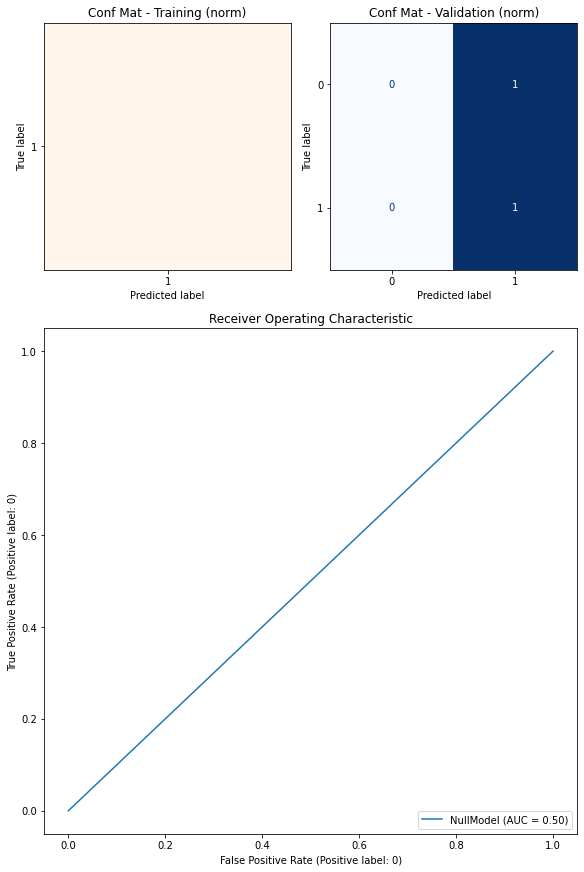

In [25]:
from src.models.performance import plot_confusion_matrix_roc

# Get baseline
plot_confusion_matrix_roc \
    ( classifier=baseline
    , feat_trn=feat_trn
    , targ_trn=bas
    , feat_val=feat_val
    , targ_val=targ_val
    )

In [26]:
# from src.models.performance import save_reg_perf

# bas = np.full(targ_trn.shape, mode(targ_trn.to_numpy()))

# # Check performance
# pred_scor = save_reg_perf \
#     ( targ=feat_trn
#     , pred=bas
#     , pred_prob=bas
#     , df_metrics=pred_scor
#     , name="Raw baseline"
#     , print_matrix=True
#     , print_plot=True
#     , print_df=False
#     )

**Results**
- As expected.
- This is a good start.

## Attempt 1: Logistic Regression - Cross Validation

In [27]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegressionCV
from src.models.predict_model import fit_predict_print

# Set regularisation space
C_list = np.linspace(0.001, 0.5, 20)

# Instantiate
cla = LogisticRegressionCV \
    ( Cs=C_list
    , cv=20
    , penalty='l1'
    , scoring='roc_auc'
    , solver='liblinear'
    , tol=1e-4
    , max_iter=1000
    , class_weight="balanced"
    , n_jobs=10
    , verbose=2
    , refit=True
    , multi_class='ovr'
    , random_state=42
    )

# Train
t.tic()
cla.fit(feat_smot_trn, targ_smot_trn)
t.toc()

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)[:,1]
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)[:,1]

# Check
print("ROC:", roc_auc_score(targ_val, pred_prob_val))

# Backup
dump(cla, "./models/01_LogRegCV_Default.joblib")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:   16.4s remaining:   10.9s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   17.5s finished
[LibLinear]Elapsed time: 0:00:18
ROC: 0.6973393002746746


['./models/01_LogRegCV_Default.joblib']

In [28]:
# Check performance
pred_scor = save_reg_perf \
    ( targ=targ_trn
    , pred=pred_trn
    , pred_prob=pred_prob_trn
    , df_metrics=pred_scor
    , name="01 - LogRegCV - Default - within bag"
    , print_all=False
    )
    
pred_scor = save_reg_perf \
    ( targ=targ_val
    , pred=pred_val
    , pred_prob=pred_prob_val
    , df_metrics=pred_scor
    , name="01 - LogRegCV - Default - out of bag"
    , print_plot=False
    )

pred      
          0     1
targ 0  259   140
     1  746  1255

,name,when,auc,sens,spec,f1
0,01 - LogRegCV - Default - within bag,27/Feb 09:12,0.70673,0.63453,0.66524,0.74591
1,01 - LogRegCV - Default - out of bag,27/Feb 09:12,0.69734,0.62719,0.64912,0.73910


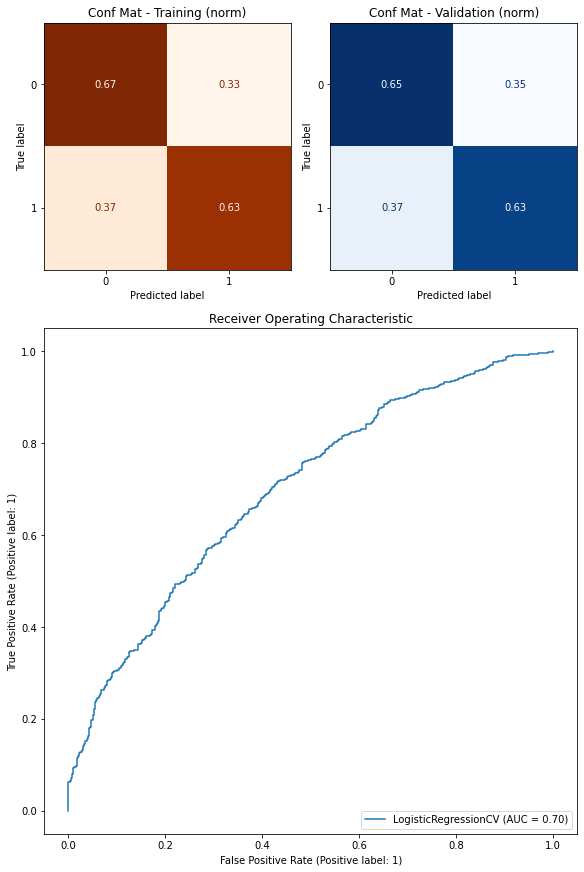

In [29]:
# Check results
plot_confusion_matrix_roc \
    ( classifier=cla
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    )

**Overview**
* k

## Attempt 2: XGBoost - Default

**Overview**
- Generate and run a stock-standard `XGBClassifier()` model.
- Use only default values.
- Don't do anything fancy.
- Expect to see better performance, but nothing extremely spectacular.

In [30]:
# Import
from xgboost import XGBClassifier

# Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )

# Train
t.tic()
cla.fit(feat_trn, targ_trn, eval_metric="auc")
t.toc()

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)[:,1]
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)[:,1]

# Check
print("ROC:", roc_auc_score(targ_val, pred_prob_val))

# Backup
dump(cla, "./models/02_XGBoost_Default.joblib")

Elapsed time: 0:00:00
ROC: 0.6480970041295142


['./models/02_XGBoost_Default.joblib']

In [31]:
# Check performance
pred_scor = save_reg_perf \
    ( targ=targ_trn
    , pred=pred_trn
    , pred_prob=pred_prob_trn
    , df_metrics=pred_scor
    , name="02 - XGBoost - Default - within bag"
    , print_all=False
    )

pred_scor = save_reg_perf \
    ( targ=targ_val
    , pred=pred_val
    , pred_prob=pred_prob_val
    , df_metrics=pred_scor
    , name="02 - XGBoost - Default - out of bag"
    , print_plot=False
    )

pred      
          0     1
targ 0   39   360
     1   79  1922

,name,when,auc,sens,spec,f1
0,01 - LogRegCV - Default - within bag,27/Feb 09:12,0.70673,0.63453,0.66524,0.74591
1,01 - LogRegCV - Default - out of bag,27/Feb 09:12,0.69734,0.62719,0.64912,0.73910
2,02 - XGBoost - Default - within bag,27/Feb 09:12,0.99960,1.00000,0.86695,0.98689
3,02 - XGBoost - Default - out of bag,27/Feb 09:12,0.64810,0.96052,0.09774,0.89750


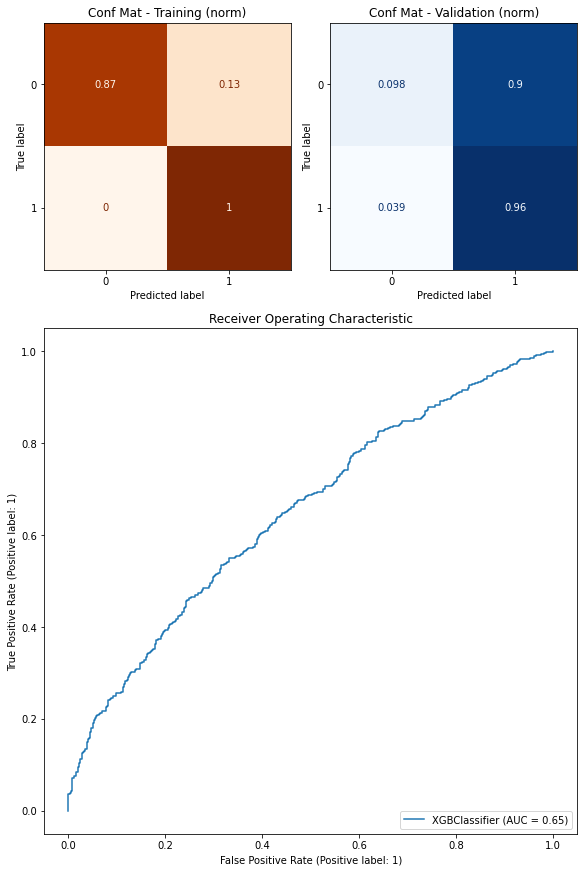

In [32]:
# Check results
plot_confusion_matrix_roc \
    ( classifier=cla
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    )

**Output**:
- Elapsed time: `0:00:00`
- Final AUC: `0.66738`
- Confusion matrix:<br>
```
    |        | pred      |
    |        | 0  | 1    |
    |targ| 0 | 46 | 353  |
    |    | 1 | 72 | 1929 |
```

**Results**
- As expected; it's better.
- Now let's see if we can tune it to get even better again.

## Attempt 2: XGBoost - Random Search

**Overview**
- As re-defining Random Search processes can be teadious, I've defined a re-usable function that will do all the leg-work for me.
- The anticipated outcome is that it will be better than what is modelled above.

In [33]:
# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=50, high=500)
    , learning_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    , max_depth=randint(low=1, high=200)
    , subsample=uniform(loc=0, scale=1)
    , colsample_bytree=uniform(loc=0, scale=1)
    , gamma=uniform(loc=0, scale=1)
    , reg_alpha=uniform(loc=0, scale=1)
    , reg_lambda=uniform(loc=0, scale=1)
    )

In [34]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Get baseline of full data set
cla, pred_scor = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    , df_metrics=pred_scor
    , n_iter=10
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=True
    , dump_name="03_XGBoost_RandomSearch"
    , print_all=True
    , print_df=True
    , print_plot=False
    )

Elapsed time: 0:00:52
Best score: 0.6860225181180974
Best params: {'colsample_bytree': 0.6964691855978616, 'gamma': 0.28613933495037946, 'learning_rate': 1e-05, 'max_depth': 99, 'n_estimators': 280, 'reg_alpha': 0.719150310154773, 'reg_lambda': 0.49111893343259727, 'subsample': 0.7800277619120791}


pred      
          0     1
targ 0   11   388
     1    9  1992

,name,when,auc,sens,spec,f1
0,01 - LogRegCV - Default - within bag,27/Feb 09:12,0.70673,0.63453,0.66524,0.74591
1,01 - LogRegCV - Default - out of bag,27/Feb 09:12,0.69734,0.62719,0.64912,0.73910
2,02 - XGBoost - Default - within bag,27/Feb 09:12,0.99960,1.00000,0.86695,0.98689
3,02 - XGBoost - Default - out of bag,27/Feb 09:12,0.64810,0.96052,0.09774,0.89750
4,03 - XGBoost - RandomSearch - within bag,27/Feb 09:13,0.88210,1.00000,0.21674,0.92748
5,03 - XGBoost - RandomSearch - out of bag,27/Feb 09:13,0.69606,0.99550,0.02757,0.90938


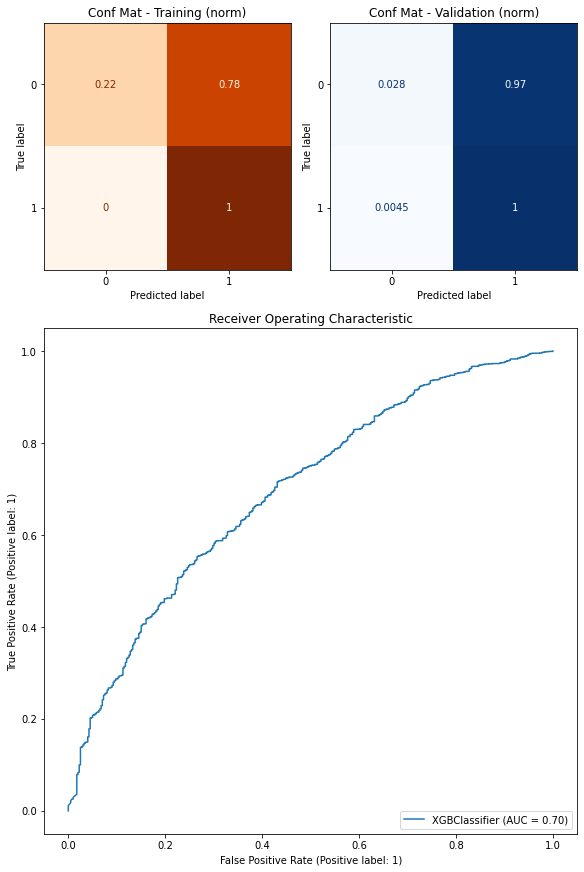

In [35]:
# Check results
plot_confusion_matrix_roc \
    ( classifier=cla
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    )

**Output**:
- Elapsed time: `0:08:49`
- Best score: `0.6934866835784483`
- Final AUC: `0.70406`
- Best params: <br>
`{ 'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 4 | 395  |
    |    | 1 | 4 | 1997 |
```

**Results:**
- As expected, the AUC is indeed higher.
- It's interesting that the algorithm chose the hyperparameters that it did. Particularly:
    - `max_depth`: I would have thought that it would have gone deeper than only `4` levels?
    - `n_estimators`: Yes, this number seems about right. However, given the small data set, I would have expected it to go a lot higher though.
    - `learning_rate`: This is a fairly typical learning rate; nothing overly remarkable here.
    - `alpha`, `lambda`, `gamma`: The regularisation is slightly on the lower side of `0.5`, but still quite conservative for the `gamma` and `alpha` parameters; though for `lambda` it has gone quite low to `0.2`. As `alpha` represents `l1` regularisation, it is quite interesting that it would have chosen to increase this value to the extent that it did.
- The model doesn't look like it's overfitting; though I'm still not overly satisfied with the results.
- Further experimentation is needed arount the feature selection aspects.

# Examine Model

**Overview**
- Let's take a look at the different parts of the model.
- Mostly interested in the visualisation of the Feature Importances

# Final Processing & Submitting

## Define final processing steps

In [27]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="./data/raw/test.csv"
    , test_col_indices=None
    , submission_data_path:str="./data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "./data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "./data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd
    from src.utils.misc import str_right

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    assert isinstance(test_col_indices, (type(None), list))
    if isinstance(test_col_indices, list):
        assert np.all([isinstance(i, int) for i in test_col_indices])
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop('Id')
    test_data = test_data.drop(['Id_old'], axis=1)
    test_data = data_scaler.fit_transform(test_data)
    if not test_col_indices is None:
        test_data = test_data[:, test_col_indices]

    # Get prediction
    final_prediction = final_model.predict_proba(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction[:,1])], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    # submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [28]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "./models/Chris/15_XGBoost_RandomSearch_FeatureSelection.joblib"
    , data_scaler_path = "./models/Chris/scaler.joblib"
    , test_data_path = "./data/raw/test.csv"
    , test_col_indices = pcts
    , submission_data_path = "./data/external/final.csv"
    , check = True
    )

,Id,TARGET_5Yrs
0,0,0.504316
1,1,0.504441
2,2,0.506493
3,3,0.506498
4,4,0.504183
...,...,...
3794,3794,0.506547
3795,3795,0.504704
3796,3796,0.503785
3797,3797,0.506516


## Submit to Kaggle

In [29]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [30]:
# Call the API
if False:
    call_kaggle_api \
        ( upload_file = "./data/external/final.csv"
        , upload_message = "CtrlAltElite_XGBoost_RandomSearch_FeatureSelection"
        )